# Data exploration &Visualization

Before runing this notebook, you should have runned the ./DataLoader/Erowid.ipynb file to download user experiences and save them to 'experiences.pickle'.

In [40]:
import sys
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from nltk.corpus import stopwords
import nltk
import re

sys.path.append('../lexical_diversity-master/')
import lexical_diversity as ld

ModuleNotFoundError: No module named 'lexical_diversity'

In [2]:
drugs = ["Alcohol", "Amphetamines", "Ayahuasca", "Caffeine", "Cannabis", "Cocaine", "Codeine", "DMT", "Dreams", "Heroin", "Ketamine", "Kratom", "LSD", "MDMA", "Methamphetamine", "Mushrooms", "Opiates", "Opioids", "Salvia_divinorum", "Stimulants"]
wordClasses = ["adjective", "verb", "conjuction", "noun", "adverb"]

destination_folder = './Data/preProcessed/'

## Loading, preprocessing and saving the preprocessed data

In [3]:
with open('./Data/experiences.pickle', 'rb') as handle:
    contents = pickle.load(handle)

In [4]:
contents.keys()

dict_keys(['25INBOMe', '2CB', '2CE', '2CI', '2CT2', '2CT7', '5MeODMT', '5MeODiPT', 'AMT', 'Alcohol', 'Amanitas', 'Amphetamines', 'Ayahuasca', 'Benzodiazepines', 'Cacti', 'Caffeine', 'Cannabinoid_Receptor_Agonists', 'Cannabis', 'Cocaine', 'Codeine', 'DMT', 'DPT', 'DXM', 'Datura', 'Dimenhydrinate', 'Diphenhydramine', 'Dreams', 'GHB', 'HB_Woodrose', 'Harmala_Alkaloids', 'Heroin', 'Hydrocodone', 'Inhalants', 'Kava', 'Ketamine', 'Kratom', 'LSD', 'MDMA', 'Methamphetamine', 'Methoxetamine_', 'Morning_Glory', 'Mushrooms', 'NBOMe_Series', 'NMDA_Antagonists', 'Nitrous_Oxide', 'Nutmeg', 'Opiates', 'Opioids', 'Pharmaceuticals', 'Pharms_Oxycodone', 'Pharms_Tramadol', 'Pharms_Zolpidem', 'Phenethylamine', 'SSRIs', 'Salvia_divinorum', 'Stimulants', 'Syrian_Rue'])

The next step may take a while due to the preprocessing steps applied on all of the data. These steps include:
- lemmatization,
- converting to lowercase,
- cleaning up from extra characters (such as >, >=, <, <=, ;, /, ?, ., *, ?, &,+)
- cleaning up from digits.

## Helping functions for preprocessing, loading and saving the data

In [5]:
def getErowidExperiences(contents, separately = False, pre_process_text = False, word_class = None, drugs = None):
    experiences = {}

    if not isinstance(contents, dict):
        raise ValueError("The first parameter should be a dictionary.")
        
    for drug in contents.keys():
        if drugs != None and drug in drugs:
            if separately:
                experiences[drug] = [clean_and_filter_text(exp["text"], word_class) if pre_process_text else exp["text"] for exp in contents[drug]]
            else:
                experiences[drug] = ' '.join([clean_and_filter_text(exp["text"], word_class) if pre_process_text else exp["text"] for exp in contents[drug]])
        else: 
            continue
        
    return experiences

# Disclaimer: https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file
def save_obj(obj, name, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

    with open(folder + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name, folder):
    with open(folder + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

def clean_and_filter_text(text, word_class = None):
    text = text.lower()
    text = re.sub(r'\w*\d\w*','', text).strip()
    text = re.sub("&lt;/?.*?&gt;&le&ge+\\\\",'', text).strip()
    text = lemmatize_and_filter_text(text, word_class)

    return text


## Preprocess and save the data

In [ ]:
experiencesAll = getErowidExperiences(contents, separately = False, pre_process_text = True, drugs = drugs)
save_obj(experiencesAll, "experiencesAll", destination_folder)

experiencesSep = getErowidExperiences(contents, separately = True, pre_process_text = True, drugs = drugs)
save_obj(experiencesSep, "experiencesSep", destination_folder)

for wordClass in wordClasses:
    experiencesAll = getErowidExperiences(contents, separately = False, pre_process_text = True, word_class = wordClass, drugs = drugs)
    save_obj(experiencesAll, "experiencesAll_"+ wordClass, destination_folder)
    
    experiencesSep = getErowidExperiences(contents, separately = True, pre_process_text = True, word_class = wordClass, drugs = drugs)
    save_obj(experiencesSep, "experiencesSep_"+ wordClass, destination_folder)

Both, experiencesAll and experiencesSep contains the experiences in a dictionary with the name of the drug as the key. However, in experiencesAll all the experiences belonging to one substance are concatenated into one text, whereas in the experiencesSep they are saved seperately. 

## Loading the preprocessed data

In [6]:
experiencesSep = {}
experiencesSep["experiencesSep_all"] = load_obj("experiencesSep", destination_folder)

experiencesAll = {}
experiencesAll["experiencesAll_all"] = load_obj("experiencesAll", destination_folder)

for wordClass in wordClasses:
    experiencesSep["experiencesSep_" + wordClass] = load_obj("experiencesSep_" + wordClass, destination_folder)
    experiencesAll["experiencesAll_" + wordClass] = load_obj("experiencesAll_" + wordClass, destination_folder)

## Wordclouds per drug - most often used words

In [6]:
experiencesAll.keys()

dict_keys(['experiencesAll_all', 'experiencesAll_adjective', 'experiencesAll_verb', 'experiencesAll_conjuction', 'experiencesAll_noun', 'experiencesAll_adverb'])

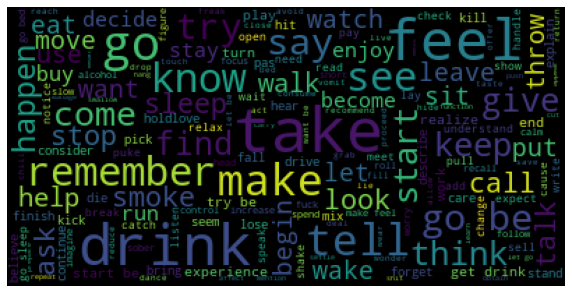

In [5]:
mf.plotCloud(experiencesAll, "Alcohol", "verb").show()

To plot a simple wordcloud of the experiences is not helpful, given that many words are not helpful and many words appear in more experiences. Hence, the _most unique words_ per experiences (or with other words: the keywords) should be plotted. To find these words, the common TF-IDF method is used.

## Finding the keywords based on TF-IDF scores

Instead of [implementing TF-IDF from scratch](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089), the one from the sklearn is used ([with the help of this post](https://towardsdatascience.com/how-to-rank-text-content-by-semantic-similarity-4d2419a84c32)):

In [7]:
current_drug = 'Cannabis'

Define stop words, add the current_drog to the stop words and find word counts:

### Helping functions to clean the text and filter by word classes

In [11]:
class lemmaTokenizer:
    ignore_tokens = [',',';',':','"',"'",'`','.','˝','\\','/','+', '?', '!', '”', '“', '’', '...','``',"''"]
    def __init__(self):
        self.wnl = nltk.WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(self.wnl.lemmatize(t,"v")) for t in nltk.word_tokenize(doc) if t not in self.ignore_tokens]
 
def lemmatize_and_filter_text(text, word_class = None):
    tokenizer = lemmaTokenizer()
    lemmatized_tokens = tokenizer(text)
    
    if word_class != None:
        lemmatized_tokens = filter_tag(lemmatized_tokens, word_class)
            
    return ' '.join(lemmatized_tokens)
    
def filter_tag(tokens, tag):
    tagged_text = nltk.pos_tag(tokens)
    return [tuplet[0] for tuplet in tagged_text if tuplet[1] == mapTag(tag)]
    
def mapTag(tag):
    if tag not in ('adjective', 'verb', 'conjuction', 'noun', 'adverb'):
        print("The 'tag' parameter should be either 'adjective', 'verb', 'conjuction', 'noun', 'adverb'.")
        raise ValueError

    tagMap = {"adjective": "JJ",
              "verb": "VB",
              "conjuction": "CC",
              "noun": "NN",
              "adverb": "RB"}
    
    return tagMap[tag]

def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

def create_one_array(d):
    arr = []
    for k in d.keys():
        [arr.append(experience) for experience in d[k]]
    
    return arr

### Set stopwords and create a 'dictionary' with CountVectorizer

In [12]:
stop_words = set(stopwords.words('english'))
stop_words.add(current_drug.lower()) 
tokenizer = lemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))
cv = CountVectorizer(max_df = 0.9, stop_words = token_stop)
word_count = cv.fit_transform(create_one_array(without_keys(experiencesSep["experiencesSep_all"], current_drug)))
word_count.shape

(2856, 26965)

We can see, that we have 2856 experiences besides the ones about the current drug (Cannabis) and there are 26 965 unique words (excluded the stopp word, single character words and the ones which are in the 90% of the texts).

### Helping functions to receive the top n words by TF-IDF scores

In [13]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse = True)

def extract_topn_from_vector(feature_names, sorted_items, topn = 10):
    
    sorted_items = sorted_items[:topn]
    
    score_vals = []
    feature_vals = []
    
    for i, score in sorted_items:
        score_vals.append(round(score,3))
        feature_vals.append(feature_names[i])
        
    results = {}
    for i in range(len(feature_vals)):
        results[feature_vals[i]] = score_vals[i]
        
    return results

In [14]:
transformer = TfidfTransformer(smooth_idf = True, use_idf = True)
transformer.fit(word_count)
feature_array = cv.get_feature_names()

In [36]:
tf_idf_vector = transformer.transform(cv.transform([experiencesAll["experiencesAll_adjective"][current_drug]]))
sorted_items = sort_coo(tf_idf_vector.tocoo())
current_keywords = extract_topn_from_vector(feature_array, sorted_items, 1000)
print("First 10 keywords:")
{k: current_keywords[k] for k in list(current_keywords)[:10]}

First 10 keywords:


{'high': 0.25,
 'good': 0.212,
 'little': 0.21,
 'first': 0.203,
 'much': 0.161,
 'next': 0.157,
 'different': 0.15,
 'last': 0.141,
 'bad': 0.128,
 'new': 0.126}

### Repeat these steps for each drug and word classes

In [23]:
keywords = {}

def find_keywords(experiencesAll, experiencesSep, current_drug, word_class = "all", topn = 50, max_df = 0.9):
    stop_words = set(stopwords.words('english'))
    stop_words.add(current_drug.lower())
    tokenizer = lemmaTokenizer()
    token_stop = tokenizer(' '.join(stop_words))
    
    cv = CountVectorizer(max_df = max_df, stop_words = token_stop)
    word_count = cv.fit_transform(create_one_array(without_keys(experiencesSep["experiencesSep_" + word_class], current_drug)))

    transformer = TfidfTransformer(smooth_idf = True, use_idf = True)
    transformer.fit(word_count)
    feature_array = cv.get_feature_names()

    tf_idf_vector = transformer.transform(cv.transform([experiencesAll["experiencesAll_" + word_class][current_drug]]))
    sorted_items = sort_coo(tf_idf_vector.tocoo())
    keywords = extract_topn_from_vector(feature_array, sorted_items, topn)
    
    return keywords

In [35]:
current_keywords = find_keywords(experiencesAll, experiencesSep, "Cannabis", "adjective", topn = 100)
print("First 10 keywords:")
{k: current_keywords[k] for k in list(current_keywords)[:10]}

First 10 keywords:


{'high': 0.238,
 'first': 0.203,
 'little': 0.201,
 'good': 0.2,
 'much': 0.179,
 'next': 0.15,
 'different': 0.141,
 'last': 0.132,
 'bad': 0.12,
 'new': 0.118}

## Wordclouds per drug II. - based on keywords and their TF-IDF scores

### Helping function for visualization

In [26]:
def plotCloud(frequencies = None, text = None, mask = None, make_plot = True):
    if text == None and frequencies == None:
        raise ValueError("Either the 'text' or the 'frequencies' parameter should be defined!")
    
    if text != None and not isinstance(text, str):
        raise TypeError("ExperiencesAll['experiencesAll_&wordclass']['&drug'] should be given for the text parameter.")
    
    if frequencies != None and not isinstance(frequencies, dict):
        raise TypeError("The parameter 'frequencies' should be a dictionary with the top words as keys and the TF-IDF scores as values.")
    
    mask = np.array(Image.open("./masks/" + mask + ".jpg"))
    
    wordcloud = WordCloud(max_font_size=45, relative_scaling=0.5, mask = mask, contour_width=3, contour_color='green')
    if text != None:
        wordcloud = wordcloud.generate_from_text(text)
    else:
        wordcloud = wordcloud.generate_from_frequencies(frequencies = frequencies)
    
    
    plt.ioff()
    
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    
    if make_plot:
        plt.show()
        return
    
    plt.ion()
    
    return plt


### Plot the wordcloud

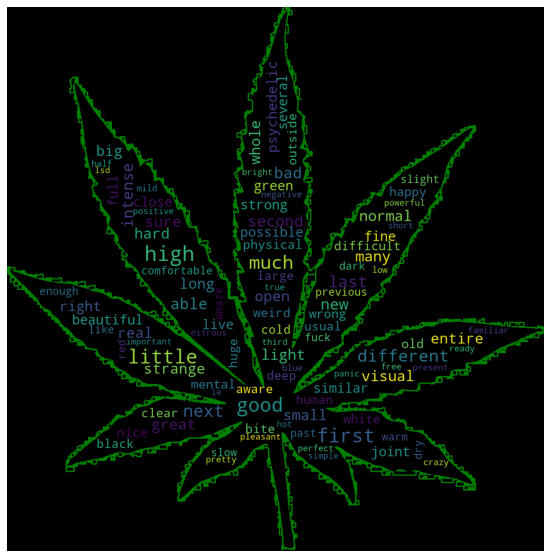

In [27]:
plotCloud(frequencies = current_keywords, mask = current_drug)

## Analyse and compare the lexical diversity for each drug

Disclaimer: https://github.com/jennafrens/lexical_diversity

To analyse the _lexical diversity_ of the experiences 
- HD-D (see McCarthy, P.M. & Jarvis, S. (2007). vocd: A theoretical and empirical evaluation. Language Testing, 24(4), 459-488) and
- MTLD (Measure of Textual Lexical Diversity, or LDAT, Lexical Diversity Assessment Tool, see McCarthy, P. M., & Jarvis, S. (2010). MTLD, vocd-D, and HD-D: A validation study of sophisticated approaches to lexical diversity assessment. Behavior research methods, 42(2), 381-392) 
are used.

The lexical diversity of the experiences are compared by each drug used by the both measurements.

## Resources

- [How to use TFidftransformer & Tfidfvectorizer?](https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X9sJhthKhPZ)
- [How to extract keywords from text with TF-IDF and Python's Scikit-learn](https://www.freecodecamp.org/news/how-to-extract-keywords-from-text-with-tf-idf-and-pythons-scikit-learn-b2a0f3d7e667/)